# Assignmet 2
## Preprocessing data

In [54]:
import pandas as pd
import regex as re
import numpy as np
book = pd.read_csv("BX-Books.csv")
rating = pd.read_csv("BX-Ratings.csv")
user = pd.read_csv("BX-Users.csv")

In [55]:
user["User-Age"] = user.apply(
    lambda row: re.sub(r'\"$', "", row["User-Age"]) if not pd.isna(row["User-Age"]) else row["User-Age"],
    axis=1
)
# impute user age
user["User-Age"].fillna(user["User-Age"].median(), inplace=True)
user.astype({
    "User-Age": "int32",
})
user["User-Age"] = user["User-Age"].astype(int)

 Removing age outliers

In [56]:
# Remove Age outlier
outliers = user[(user["User-Age"] < 5) | (user["User-Age"] >= 100)]
user.drop(outliers.index, inplace=True)

In [57]:
user.drop(["User-City", "User-State"], axis = 1, inplace=True)

In [58]:
def discretize_age_group(age):
    if age <= 16:
        return "Child"
    elif 17 <= age <= 30:
        return "Young Adult"
    elif 31 <= age <= 45:
        return "Middle-Aged Adult"
    else:
        return "Old-aged Adult"

In [59]:
age_group_counts = user["User-Age"].value_counts()

In [60]:
user["User-Age"] = user["User-Age"].apply(lambda age : discretize_age_group(age))

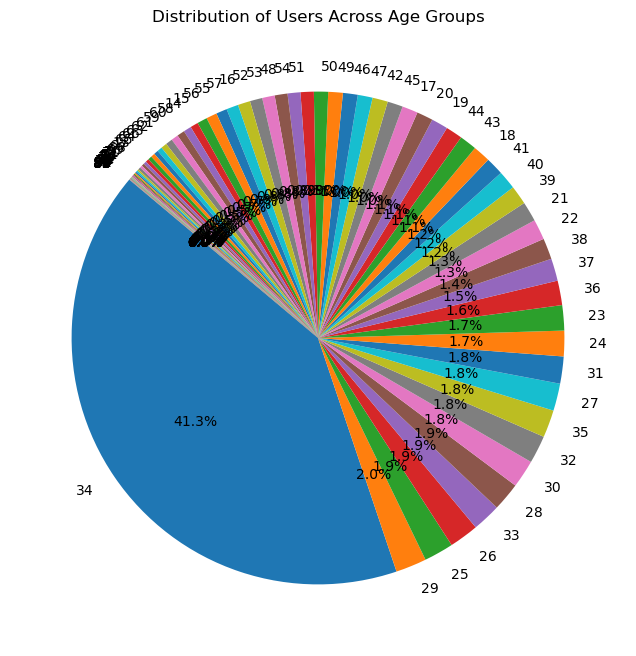

In [61]:
import matplotlib.pyplot as plt

# Plotting pie chart for number of users from each age group
plt.figure(figsize=(8, 8))
plt.pie(age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Users Across Age Groups')
plt.show()

In [62]:
def filter_ratings_by_user(users_df, ratings_df):
    user_ids = users_df["User-ID"]
    filtered_ratings_df = ratings_df[ratings_df['User-ID'].isin(user_ids)]
    return filtered_ratings_df
rating = filter_ratings_by_user(user, rating)

### Cleaning the country's name

In [63]:
# remove trailing double quote
user["User-Country"] = (user['User-Country']
                        .apply(lambda country: re.sub(r'\"$', "", country) if not pd.isna (country) else country))

In [64]:
%pip install pycountry
import pycountry as pc
import pprint
matchCountryMap = {}
naCountries = {}
countries = pd.Series(user["User-Country"].unique())
naCount = 0
possibleNANames = ["n/a", "na"]
notFoundCountries = []
for country in countries:
    if not pd.isna(country):
        if not country.lower() in possibleNANames:
            countryName = str(country)
            countryName = countryName.title()
            try:
                if "." in countryName:
                    countryName = countryName.replace(".","").upper()
                matchCountryMap[country] = pc.countries.lookup(countryName)
            except LookupError as e:
                naCount += 1
                try:
                    matchCountryMap[country] = pc.countries.search_fuzzy(countryName)[0]
                except LookupError as _:
                    notFoundCountries.append(countryName)
                    print("Not found ", countryName)
        else:
            matchCountryMap[country] = pd.NA

manualMatchCountryMap = {
    'Alderney': pc.countries.lookup("guernsey"),
    'Turkey': pc.countries.lookup("TUR"),
    'US OF A': pc.countries.lookup("USA"),
    'Tdzimi': pd.NA,
    'España': pc.countries.lookup("ESP"),
    'Lkjlj': pd.NA,
    'N/A - On The Road': pd.NA,
    'Yugoslavia': pd.NA,
    'Richmond Country': pd.NA,
    'Framingham' : pc.countries.lookup("USA"),
    'United Kindgonm': pc.countries.lookup("GB"),
    'Universe': pd.NA,
    'ST HELENA': pc.countries.lookup("SH"),
    'Aroostook': pc.countries.lookup("US"),
    'Burma': pc.countries.lookup("MM"),
    'Van Wert': pc.countries.lookup("USA"),
    'Far Away': pd.NA,
    'K1C7B1': pd.NA,
    'Rutherford': pd.NA,
    'UAE': pc.countries.lookup("ARE"),
    'Petrolwar Nation': pd.NA,
    'Shelby': pd.NA,
    'Catalonia': pc.countries.lookup("ESP"),
    'Caribbean Sea': pd.NA,
    'Cananda': pc.countries.lookup("CA"),
    'Pender': pd.NA,
    'La France': pc.countries.lookup("FR"),
    'Phillipines': pc.countries.lookup("PHL"),
    'Los Estados Unidos De Norte America': pc.countries.lookup("USA"),
    'Orange Co': pc.countries.lookup("USA"),
    'Unknown': pd.NA,
    'L`Italia': pc.countries.lookup("IT"),
    'Kern': pd.NA,
    'STTHOMASI': pd.NA,
    'Everywhere And Anywhere': pd.NA,
    'United Staes': pc.countries.lookup("USA"),
    'Deutschland': pc.countries.lookup("DE"),
}


Note: you may need to restart the kernel to use updated packages.
Not found   Alderney
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='GB-ENG', country_code='GB', name='England', parent_code=None, type='Country')
Not found   N/A
Not found   Turkey
Not found   US OF A
Not found   Tdzimi
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
Not found   España
SubdivisionHierarchy(code='BD-13', country_code='BD', name='Dhaka', parent='C', parent_code='BD-C', type='District')
SubdivisionHierarchy(code='BD-15', country_code='BD', name='Faridpur', parent='C', parent_code='BD-C', type='District')
SubdivisionHierarchy(code='BD-17',

In [65]:
def matchCountry(name):
    if not pd.isna(name):
        country = 0
        if name in matchCountryMap:
            country = matchCountryMap.get(name)
        else:
            country = manualMatchCountryMap.get(name)
        if country is pd.NA or country is None: return "others"
        return country.name
    return "others"
# 
user["User-Country"] = user["User-Country"].apply(
    lambda name: matchCountry(name)
)
user["User-Country"]

0               Canada
1        United States
2        United States
3        United States
4               others
             ...      
48294           Canada
48295           Canada
48296    United States
48297        Australia
48298    United States
Name: User-Country, Length: 48115, dtype: object

Books dataset

In [66]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # casefolding
    text = str(text).lower()
    # remove all non-alphabetic character
    letters_only = re.sub(r'[^a-zA-Z]', ' ', text)
    # tokenization
    tokens = word_tokenize(letters_only)
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    return text

# Assuming "books" is a DataFrame and "Book-Title" is one of its columns
book["preprocessed_title"] = book["Book-Title"].apply(preprocess_text)
book["Book-Author-processed"] = book["Book-Author"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ducbui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ducbui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ducbui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [67]:
book

ISBN                                         Book-Title  \
0      0002005018                                       Clara Callan   
1      0374157065  Flu: The Story of the Great Influenza Pandemic...   
2      0399135782                             The Kitchen God's Wife   
3      0440234743                                      The Testament   
4      0452264464               Beloved (Plume Contemporary Fiction)   
...           ...                                                ...   
18180  0375411615                                         Love, Etc.   
18181  0836227751              The Wit And Whimsy Of Mary Engelbreit   
18182  8433966634                            Los Detectives Salvajes   
18183  0330353349                  The Ice House (TV Tie-In Edition)   
18184  0394757645  Trouble Is My Business (Vintage Crime/Black Li...   

                Book-Author  Year-Of-Publication             Book-Publisher  \
0      Richard Bruce Wright                 2001      HarperFlamingo Canada   
1          Gina Bari Kolata                 1999       Farrar Straus Giroux   
2                   Amy Tan                 1991           Putnam Pub Group   
3              John Grisham                 1999                       Dell   
4             Toni Morrison                 1994                      Plume   
...                     ...                  ...                        ...   
18180         Julian Barnes                 2001            Alfred A. Knopf   
18181       Mary Engelbreit                 1997  Andrews McMeel Publishing   
18182        Roberto Bolano                 2003                   Anagrama   
18183       Minette Walters                 1997       McClelland & Stewart   
18184      Raymond Chandler                 1992          Vintage Books USA   

                                      preprocessed_title Book-Author-processed  
0                                           clara callan  richard bruce wright  
1      flu story great influenza pandemic search viru...      gina bari kolata  
2                                       kitchen god wife               amy tan  
3                                              testament          john grisham  
4                     beloved plume contemporary fiction         toni morrison  
...                                                  ...                   ...  
18180                                           love etc         julian barnes  
18181                         wit whimsy mary engelbreit       mary engelbreit  
18182                             los detective salvajes        roberto bolano  
18183                           ice house tv tie edition        minette walter  
18184        trouble business vintage crime black lizard      raymond chandler  

[18185 rows x 7 columns]

# Data exploration

In [68]:
user.describe()

User-ID
count   48115.000000
mean   139551.696893
std     80430.008962
min         8.000000
25%     69164.000000
50%    138849.000000
75%    209416.500000
max    278854.000000

In [69]:
user["User-Country"].value_counts()

User-Country
United States     34358
Canada             4595
Germany            1852
United Kingdom     1778
Australia           974
                  ...  
Guatemala             1
Cuba                  1
Albania               1
Bahrain               1
Ghana                 1
Name: count, Length: 125, dtype: int64

In [70]:
# Return top popular and highest rating books to new user
def topBook(numBook):
    rating_counts = rating["ISBN"].value_counts().rename("Rating-Count")
    book_updated = pd.merge(book, rating_counts, left_on="ISBN", right_index=True, how="left")
    book_updated.sort_values(by=["Rating-Count"], ascending=False, inplace=True)
    topPopular = book_updated.head(numBook)
    return topPopular
topBook(10)

ISBN                                         Book-Title  \
223   0316666343                          The Lovely Bones: A Novel   
7     0971880107                                        Wild Animus   
401   0385504209                                  The Da Vinci Code   
276   0312195516                The Red Tent (Bestselling Backlist)   
589   0060928336    Divine Secrets of the Ya-Ya Sisterhood: A Novel   
1136  059035342X  Harry Potter and the Sorcerer's Stone (Harry P...   
198   0142001740                            The Secret Life of Bees   
381   0446672211  Where the Heart Is (Oprah's Book Club (Paperba...   
172   044023722X                                    A Painted House   
127   0452282152                          Girl with a Pearl Earring   

          Book-Author  Year-Of-Publication           Book-Publisher  \
223      Alice Sebold                 2002            Little, Brown   
7        Rich Shapero                 2004                  Too Far   
401         Dan Brown                 2003                Doubleday   
276     Anita Diamant                 1998              Picador USA   
589     Rebecca Wells                 1997                Perennial   
1136    J. K. Rowling                 1999   Arthur A. Levine Books   
198     Sue Monk Kidd                 2003            Penguin Books   
381      Billie Letts                 1998             Warner Books   
172      John Grisham                 2001  Dell Publishing Company   
127   Tracy Chevalier                 2001              Plume Books   

                                     preprocessed_title Book-Author-processed  \
223                                   lovely bone novel          alice sebold   
7                                           wild animus          rich shapero   
401                                       da vinci code             dan brown   
276                       red tent bestselling backlist         anita diamant   
589                divine secret ya ya sisterhood novel          rebecca well   
1136  harry potter sorcerer stone harry potter paper...           j k rowling   
198                                     secret life bee         sue monk kidd   
381                     heart oprah book club paperback          billie letts   
172                                       painted house          john grisham   
127                                  girl pearl earring       tracy chevalier   

      Rating-Count  
223            670  
7              574  
401            477  
276            361  
589            310  
1136           303  
198            300  
381            279  
172            273  
127            265

Text(0.5, 1.0, 'User Countries (Excluding Smaller Countries)')

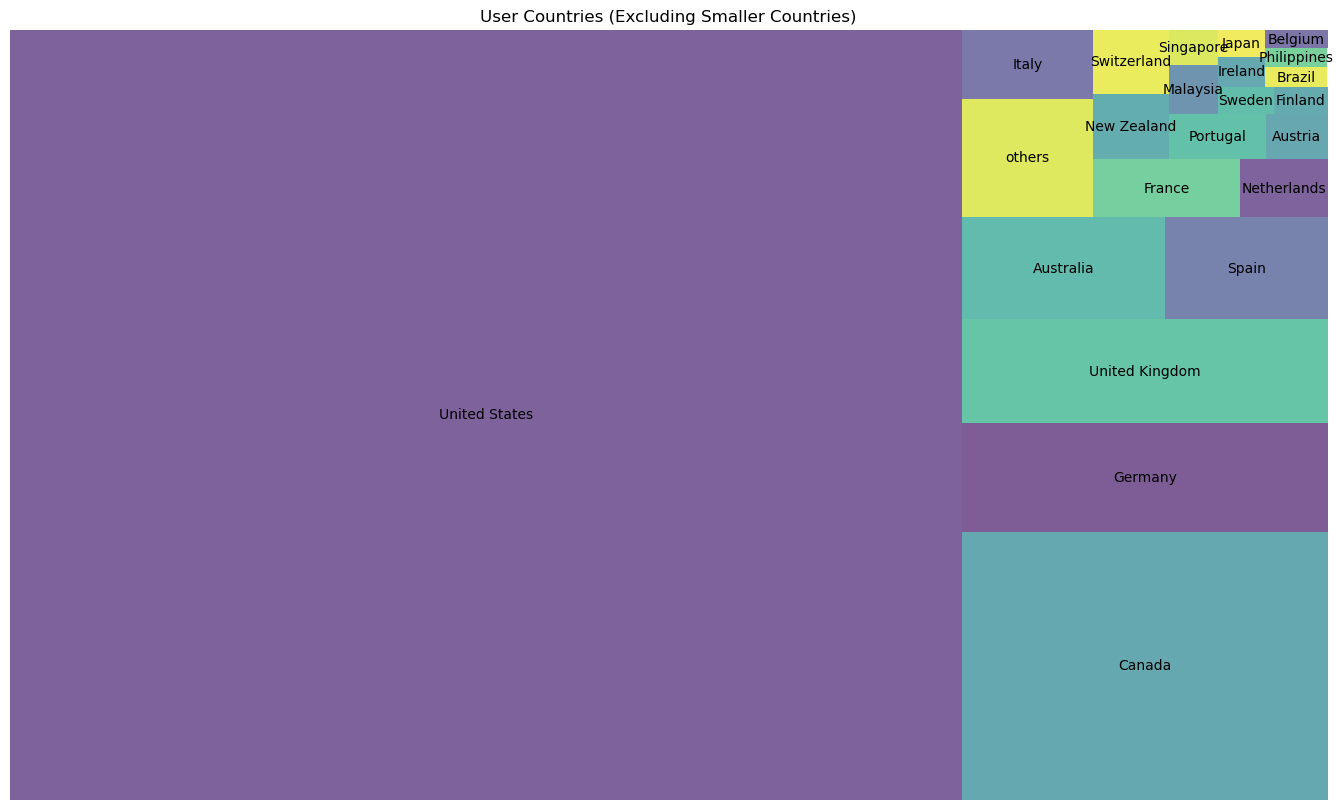

In [71]:
#pip install squarify
import matplotlib.pyplot as plt
import squarify
country_counts = user['User-Country'].value_counts()
large_countries = country_counts[country_counts >= 50]

# Create a squarify treemap
plt.figure(figsize=(17, 10))
squarify.plot(sizes=large_countries, label=large_countries.index, alpha=0.7)
plt.axis('off')
plt.title('User Countries (Excluding Smaller Countries)')

In [72]:
rating_counts = rating["ISBN"].value_counts().rename("Rating-Count")
book = pd.merge(book, rating_counts, left_on="ISBN", right_index=True, how="left")

In [73]:
# average book rating can resolve new user issue
average_ratings = rating.groupby('ISBN')['Book-Rating'].mean().reset_index()
# Merge average_ratings with book_df
book = pd.merge(book, round(average_ratings), on='ISBN', how='left')

Text(0.5, 1.0, 'Average Rating of Books for Top 10 most popular Authors')

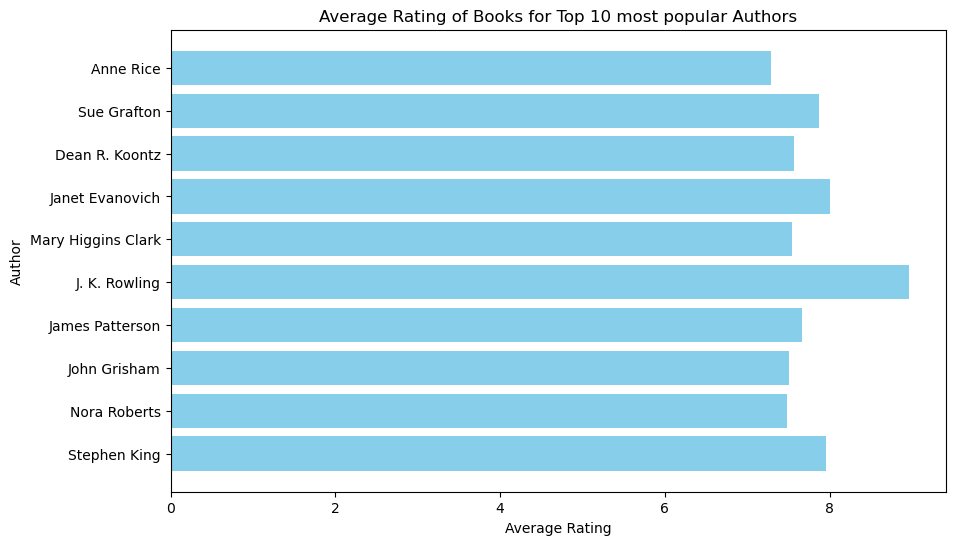

In [74]:
author_stats = book.groupby('Book-Author').agg({'Book-Rating': 'mean', 'Rating-Count': 'sum'}).reset_index()
author_stats.sort_values(by=['Rating-Count', 'Book-Rating'], ascending=[False, False], inplace=True)
top_10_authors = author_stats.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_authors["Book-Author"], top_10_authors["Book-Rating"], color='skyblue')
plt.xlabel("Average Rating")
plt.ylabel("Author")
plt.title("Average Rating of Books for Top 10 most popular Authors")

Text(0.5, 1.0, 'Rating count of Books for Top 10 Authors')

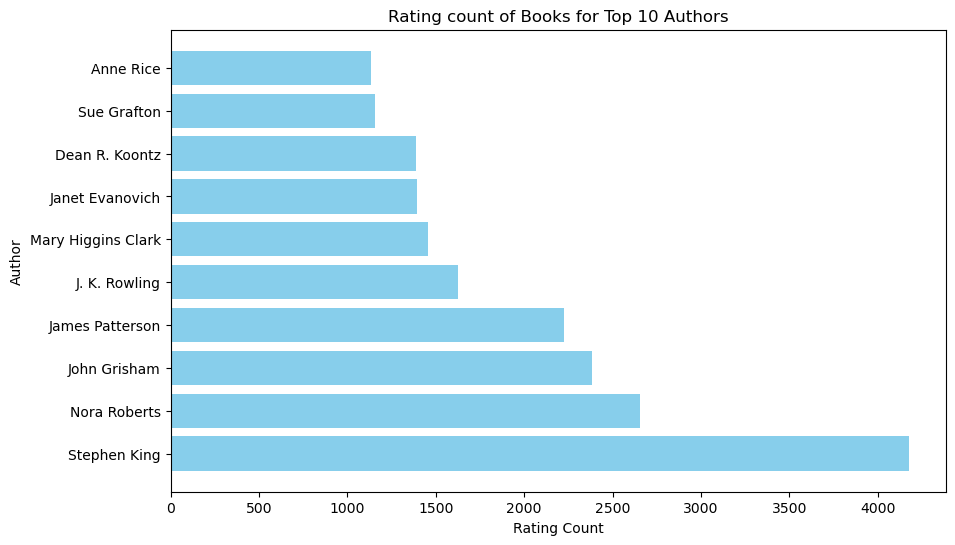

In [75]:
plt.figure(figsize=(10, 6))
plt.barh(top_10_authors["Book-Author"], top_10_authors["Rating-Count"], color='skyblue')
plt.xlabel("Rating Count")
plt.ylabel("Author")
plt.title("Rating count of Books for Top 10 Authors")

Text(0.5, 1.0, 'Count of Each Book Rating')

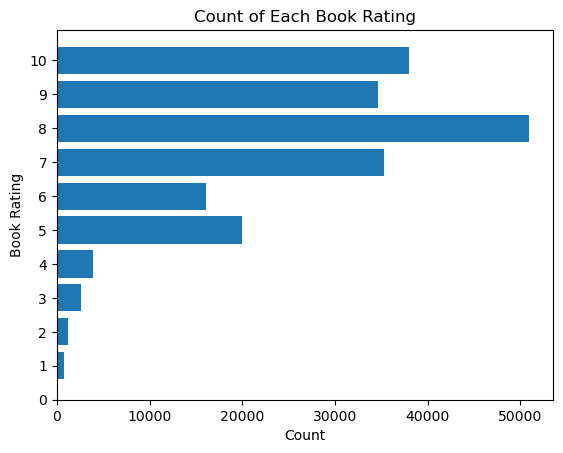

In [76]:
import matplotlib.pyplot as plt
rating_counts = rating["Book-Rating"].value_counts()
rating_counts = rating_counts.sort_index()
plt.barh(rating_counts.index, rating_counts)

plt.yticks(range(0,11))
plt.xlabel('Count')
plt.ylabel('Book Rating')
plt.title('Count of Each Book Rating')

In [77]:
def discretize_YOP_group(year):
    if year <= 1950:
        return "Before 1950"
    elif year <= 1960:
        return "1950-1960"
    elif year <= 1970:
        return "1961-1970"
    elif year <= 1980:
        return "1971-1980"
    elif year <= 1990:
        return "1981-1990"
    elif year <= 2000:
        return "1991-2000"
    else:
        return "After 2000"

In [78]:
book["Year-Of-Publication-Cat"] = book["Year-Of-Publication"].apply(lambda year : discretize_YOP_group(year))
book["Year-Of-Publication"].value_counts().sort_index()

Year-Of-Publication
0        314
1920       2
1927       1
1929       1
1930       1
        ... 
2002    1750
2003    1530
2004     475
2005       3
2030       3
Name: count, Length: 70, dtype: int64

In [79]:
yop_group_counts = book["Year-Of-Publication-Cat"].value_counts()
yop_group_counts_sorted = yop_group_counts.sort_index()

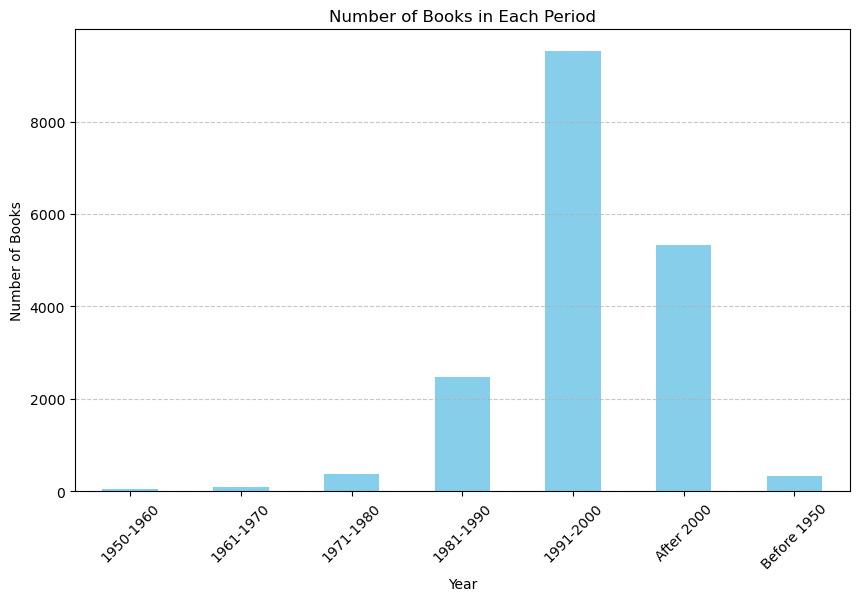

In [80]:
import matplotlib.pyplot as plt

# number of users from each age group
plt.figure(figsize=(10, 6))
yop_group_counts_sorted.plot(kind='bar', color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Books')
plt.title('Number of Books in Each Period')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [81]:
def filter_ratings_by_user(users_df, ratings_df):
    user_ids = users_df["User-ID"]
    filtered_ratings_df = ratings_df[ratings_df['User-ID'].isin(user_ids)]
    return filtered_ratings_df
rating = filter_ratings_by_user(user, rating)

# Model Training

## Collaborative filtering with SVD

In [82]:
new_rating = pd.read_csv("BX-NewBooksRatings.csv")
new_user = pd.read_csv("BX-NewBooksUsers.csv")
new_book = pd.read_csv("BX-NewBooks.csv")

In [83]:
merge_df = pd.concat([new_rating, rating], ignore_index = True)

In [84]:
user_ids = range(1, len(merge_df['User-ID'].unique()) + 1)
book_ids = range(1, len(merge_df['ISBN'].unique()) + 1)

user_mapping = dict(zip(merge_df['User-ID'].unique(), user_ids))
book_mapping = dict(zip(merge_df['ISBN'].unique(), book_ids))

rating['user_id'] = rating['User-ID'].map(user_mapping)
rating['book_id'] = rating['ISBN'].map(book_mapping)

new_rating['user_id'] = new_rating['User-ID'].map(user_mapping)
new_rating['book_id'] = new_rating['ISBN'].map(book_mapping)

In [85]:
merge_book = pd.merge(new_book, book, on = ["ISBN", "Book-Title"], how = "right")
merge_book

ISBN                                         Book-Title  \
0      0002005018                                       Clara Callan   
1      0374157065  Flu: The Story of the Great Influenza Pandemic...   
2      0399135782                             The Kitchen God's Wife   
3      0440234743                                      The Testament   
4      0452264464               Beloved (Plume Contemporary Fiction)   
...           ...                                                ...   
18180  0375411615                                         Love, Etc.   
18181  0836227751              The Wit And Whimsy Of Mary Engelbreit   
18182  8433966634                            Los Detectives Salvajes   
18183  0330353349                  The Ice House (TV Tie-In Edition)   
18184  0394757645  Trouble Is My Business (Vintage Crime/Black Li...   

      Book-Author_x  Year-Of-Publication_x Book-Publisher_x  \
0               NaN                    NaN              NaN   
1               NaN                    NaN              NaN   
2               NaN                    NaN              NaN   
3               NaN                    NaN              NaN   
4               NaN                    NaN              NaN   
...             ...                    ...              ...   
18180           NaN                    NaN              NaN   
18181           NaN                    NaN              NaN   
18182           NaN                    NaN              NaN   
18183           NaN                    NaN              NaN   
18184           NaN                    NaN              NaN   

              Book-Author_y  Year-Of-Publication_y           Book-Publisher_y  \
0      Richard Bruce Wright                   2001      HarperFlamingo Canada   
1          Gina Bari Kolata                   1999       Farrar Straus Giroux   
2                   Amy Tan                   1991           Putnam Pub Group   
3              John Grisham                   1999                       Dell   
4             Toni Morrison                   1994                      Plume   
...                     ...                    ...                        ...   
18180         Julian Barnes                   2001            Alfred A. Knopf   
18181       Mary Engelbreit                   1997  Andrews McMeel Publishing   
18182        Roberto Bolano                   2003                   Anagrama   
18183       Minette Walters                   1997       McClelland & Stewart   
18184      Raymond Chandler                   1992          Vintage Books USA   

                                      preprocessed_title  \
0                                           clara callan   
1      flu story great influenza pandemic search viru...   
2                                       kitchen god wife   
3                                              testament   
4                     beloved plume contemporary fiction   
...                                                  ...   
18180                                           love etc   
18181                         wit whimsy mary engelbreit   
18182                             los detective salvajes   
18183                           ice house tv tie edition   
18184        trouble business vintage crime black lizard   

      Book-Author-processed  Rating-Count  Book-Rating Year-Of-Publication-Cat  
0      richard bruce wright             8          8.0              After 2000  
1          gina bari kolata             6          8.0               1991-2000  
2                   amy tan            16          8.0               1991-2000  
3              john grisham           165          8.0               1991-2000  
4             toni morrison            77          8.0               1991-2000  
...                     ...           ...          ...                     ...  
18180         julian barnes             4          6.0              After 2000  
18181       mary engelbreit             4        

In [86]:
title_mapping = dict(zip(merge_book['ISBN'].unique(), merge_book["Book-Title"]))
rating['title'] = rating['ISBN'].map(title_mapping)
new_rating['title'] = new_rating['ISBN'].map(title_mapping)

In [87]:
from surprise import KNNWithMeans
from surprise import KNNBasic
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
benchmark = []
rating_df = rating[["book_id", "user_id", "Book-Rating"]]
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating_df, reader)
# Iterate over all algorithms
for algorithm in [SVD(),KNNWithMeans(), KNNBasic()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)

    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = pd.concat([tmp,pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm'])])
    benchmark.append(tmp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [88]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

test_rmse  fit_time  test_time
Algorithm                                   
SVD            1.613983  1.618202   0.093899
KNNBasic       1.786566  3.398483   1.090017
KNNWithMeans   1.792339  3.368195   1.197121

In [89]:
isbn_to_title = dict(zip(book['ISBN'], book['Book-Title']))
rating['Book-Title'] = rating['ISBN'].map(isbn_to_title)

In [90]:
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
rating_df = rating[["book_id", "user_id", "Book-Rating"]]
new_rating_df = new_rating[["book_id", "user_id", "Book-Rating"]]
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating_df, reader)
test_data = Dataset.load_from_df(new_rating_df, reader)

algo = SVD() 
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
# trainset, testset = data.build_full_trainset(), test_data.build_full_trainset()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6133  1.6208  1.6106  1.6097  1.6197  1.6148  0.0046  
MAE (testset)     1.2482  1.2503  1.2479  1.2441  1.2482  1.2477  0.0020  
Fit time          1.80    1.63    1.72    1.59    1.65    1.68    0.07    
Test time         0.11    0.39    0.09    0.09    0.34    0.20    0.13    
RMSE: 1.6211
MAE:  1.2520


1.2520242881124268

In [91]:
def recommend_book(user_id, k=10, return_val="Book-Title"):
    recommendations = []
    all_books = rating['book_id'].unique()
    for book_id in all_books:
        if rating[(rating['user_id'] == user_id) & (rating['book_id'] == book_id)].empty:
            prediction = algo.predict(user_id, book_id)
            recommendations.append((book_id, prediction.est))
    recommendations.sort(key=lambda x: x[1], reverse=True)
    top_k_recommendations = recommendations[:k]
    
    titles = []
    scores = []
    for book_info in top_k_recommendations:
        book_id = book_info[0]
        score = book_info[1]
        title = rating.loc[rating["book_id"] == book_id][return_val].iloc[0]
        titles.append(title)
        scores.append(score)
    
    df = pd.DataFrame({return_val: titles, 'Score': scores})
    return df



## TF-IDF
### Content-based Recomendation system using TF-IDF


In [92]:
books = pd.read_csv("BX-Books.csv")
merged = pd.merge(rating, books, on='ISBN')
merged

User-ID        ISBN  Book-Rating  user_id  book_id  \
0        276744  038550120X            7    11981     8925   
1         11676  038550120X           10      545     8925   
2         16877  038550120X            9      765     8925   
3         17975  038550120X            6    14715     8925   
4         20806  038550120X            6    15081     8925   
...         ...         ...          ...      ...      ...   
203314   265784  0886775809            7    11527    27108   
203315   246196  0375700110            4    47308    27109   
203316   257485  0375700110            6    48962    27109   
203317   274666  0375700110            9    51335    27109   
203318   276463  0375700110            7    51587    27109   

                                                    title  \
0                                         A Painted House   
1                                         A Painted House   
2                                         A Painted House   
3                                         A Painted House   
4                                         A Painted House   
...                                                   ...   
203314                The Law of Becoming (Jaran, Book 4)   
203315  Half and Half: Writers on Growing Up Biracial ...   
203316  Half and Half: Writers on Growing Up Biracial ...   
203317  Half and Half: Writers on Growing Up Biracial ...   
203318  Half and Half: Writers on Growing Up Biracial ...   

                                             Book-Title_x  \
0                                         A Painted House   
1                                         A Painted House   
2                                         A Painted House   
3                                         A Painted House   
4                                         A Painted House   
...                                                   ...   
203314                The Law of Becoming (Jaran, Book 4)   
203315  Half and Half: Writers on Growing Up Biracial ...   
203316  Half and Half: Writers on Growing Up Biracial ...   
203317  Half and Half: Writers on Growing Up Biracial ...   
203318  Half and Half: Writers on Growing Up Biracial ...   

                                             Book-Title_y  \
0                                         A Painted House   
1                                         A Painted House   
2                                         A Painted House   
3                                         A Painted House   
4                                         A Painted House   
...                                                   ...   
203314                The Law of Becoming (Jaran, Book 4)   
203315  Half and Half: Writers on Growing Up Biracial ...   
203316  Half and Half: Writers on Growing Up Biracial ...   
203317  Half and Half: Writers on Growing Up Biracial ...   
203318  Half and Half: Writers on Growing Up Biracial ...   

                Book-Author  Year-Of-Publication  Book-Publisher  
0              JOHN GRISHAM                 2001       Doubleday  
1              JOHN GRISHAM                 2001       Doubleday  
2              JOHN GRISHAM                 2001       Doubleday  
3              JOHN GRISHAM                 2001       Doubleday  
4              JOHN GRISHAM                 2001       Doubleday  
...                     ...                  ...             ...  
203314         Kate Elliott                 1994       Daw Books  
203315  Claudine C. O'Hearn                 1998  Pantheon Books  
203316  Claudine C. O'Hearn                 1998  Pantheon Books  
203317  Claudine C. O'Hearn                 1998  Pantheon Books  
203318  Claudine C. O'Hearn                 1998  Pantheon Books  

[203319 rows x 11 columns]

In [93]:
# %load_ext autotime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), analyzer='word')
# extract title
# merged['Book-Title-Processed'] = merged.apply(lambda row: preprocess_text(row['Book-Title'] + ' '+ row['Book-Author']), axis=1)
book['Book-Title-Processed'] = book.apply(lambda row: preprocess_text(row['Book-Title']), axis=1)

book


ISBN                                         Book-Title  \
0      0002005018                                       Clara Callan   
1      0374157065  Flu: The Story of the Great Influenza Pandemic...   
2      0399135782                             The Kitchen God's Wife   
3      0440234743                                      The Testament   
4      0452264464               Beloved (Plume Contemporary Fiction)   
...           ...                                                ...   
18180  0375411615                                         Love, Etc.   
18181  0836227751              The Wit And Whimsy Of Mary Engelbreit   
18182  8433966634                            Los Detectives Salvajes   
18183  0330353349                  The Ice House (TV Tie-In Edition)   
18184  0394757645  Trouble Is My Business (Vintage Crime/Black Li...   

                Book-Author  Year-Of-Publication             Book-Publisher  \
0      Richard Bruce Wright                 2001      HarperFlamingo Canada   
1          Gina Bari Kolata                 1999       Farrar Straus Giroux   
2                   Amy Tan                 1991           Putnam Pub Group   
3              John Grisham                 1999                       Dell   
4             Toni Morrison                 1994                      Plume   
...                     ...                  ...                        ...   
18180         Julian Barnes                 2001            Alfred A. Knopf   
18181       Mary Engelbreit                 1997  Andrews McMeel Publishing   
18182        Roberto Bolano                 2003                   Anagrama   
18183       Minette Walters                 1997       McClelland & Stewart   
18184      Raymond Chandler                 1992          Vintage Books USA   

                                      preprocessed_title  \
0                                           clara callan   
1      flu story great influenza pandemic search viru...   
2                                       kitchen god wife   
3                                              testament   
4                     beloved plume contemporary fiction   
...                                                  ...   
18180                                           love etc   
18181                         wit whimsy mary engelbreit   
18182                             los detective salvajes   
18183                           ice house tv tie edition   
18184        trouble business vintage crime black lizard   

      Book-Author-processed  Rating-Count  Book-Rating  \
0      richard bruce wright             8          8.0   
1          gina bari kolata             6          8.0   
2                   amy tan            16          8.0   
3              john grisham           165          8.0   
4             toni morrison            77          8.0   
...                     ...           ...          ...   
18180         julian barnes             4          6.0   
18181       mary engelbreit             4          9.0   
18182        roberto bolano             4          8.0   
18183        minette walter             7          7.0   
18184      raymond chandler             4          8.0   

      Year-Of-Publication-Cat  \
0                  After 2000   
1                   1991-2000   
2                   1991-2000   
3                   1991-2000   
4                   1991-2000   
...                       ...   
18180              After 2000   
18181               1991-2000   
18182              After 2000   
18183               1991-2000   
18184               1991-2000   

                                    Book-Title-Processed  
0                                           clara callan  
1      flu story great influenza pandemic search viru...  
2                                       kitchen god wife  
3                                              testament  
4                     beloved plume contemporary fiction  
...                           

In [94]:
title = book['Book-Title-Processed']
tfidf_matrix = vectorizer.fit_transform(title)

In [95]:
similarity = cosine_similarity(tfidf_matrix)
similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [96]:
def get_title_recommendation(title, cosine_sim, indices):
    # Get index of the book title

    idx = indices[title]

    sim_score = list(enumerate(cosine_sim[idx]))
    sim_score = sorted(sim_score, key=lambda x: x[0], reverse=True)
    sim_score = sim_score[0:10]
    titles_indices = [i[0] for i in sim_score]

    return books['ISBN'].iloc[titles_indices]

In [97]:
data = pd.Series(book.index, index=book['Book-Title-Processed']).drop_duplicates()

users = pd.read_csv("BX-Ratings.csv")
users = users['User-ID']

def get_rec_books(user):
    result = []
    top_book_title = book.loc[rating['User-ID'] == user]
    top_book_title = top_book_title.sort_values(by = 'Book-Rating', ascending=False)['Book-Title-Processed']

    result = get_title_recommendation(top_book_title.to_numpy(), similarity, data)

    return result
